# Deep Learning Mini-Challenge 1: Image Classification with Neuronal Networks

**Task description:** The goal of this mini-challenge is the implementation, optimization and evaluation of a neural network model for the classification of an image dataset. The focus is on the training and evaluation of the models. The evaluation is limited to Multi layer Perceptrons (MLP's) and Convolutional neural Networks (CNN's) in combination with different optimization and regularization methods.

**Description of the dataset:** For this mini challenge we use the `CIFAR10` dataset, which is a sub-set of the `Tiny images` dataset. The dataset is named after the **C**anadian **I**nstitute **F**or **A**dvanced **R**esearch. It is an image dataset and contains some 60 000 labelled images that belong to one of 10 classes. The images have a resolution of 32x32 pixels and are in RGB format. 


### Load dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from multiprocessing import cpu_count

import wandb

import copy
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

os.environ["WANDB_SILENT"] = "True"

### Device configuration

Check for allocated devices that can be used for training of the Models.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Weights and Biases init configuration

In [3]:
wandb.login()

True

In [4]:
import pandas as pd 
import wandb

api = wandb.Api()
entity, project = "simonluder", "del-mc1"  # set to your entity and project 
runs = api.runs(entity + "/" + project) 

summary_list, config_list, name_list, history_list = [], [], [], []
for i, run in enumerate(runs): 
    if i % 20 == 0:
        print("Reading model:", i)
        
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)
    
    # .history creates a history dataframe of all logged metrics
    history_list.append(run.history())

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
         if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

Reading model: 0
Reading model: 20


In [5]:
config_list
name_list

len(summary_list)
history_list

df_history_summary = pd.DataFrame()
df_config_summary = pd.DataFrame()
for i, name in enumerate(name_list):
    history_list[i]["name"] = name
    df_history_summary = pd.concat([df_history_summary, history_list[i]])
    config_list[i]["name"] = name
    df_config_summary = df_config_summary.append(config_list[i], ignore_index=True)

In [6]:
df_config_summary

,variant,drop_out,num_conv,pool_size,num_epochs,num_hidden,conv_layers,kernel_size,hidden_layers,learning_rate,l2_weight_decay,name
0,CNN_SGD,0.0,2.0,2.0,3.0,2.0,"[32, 32]",5.0,"[128, 64]",0.05,0.0,2022-05-20-20-36-48
1,CNN_SGD,0.0,2.0,2.0,3.0,2.0,"[64, 64]",5.0,"[128, 64]",0.05,0.0,eager-sweep-2
2,CNN_SGD,0.0,2.0,2.0,3.0,2.0,"[32, 32]",5.0,"[128, 64]",0.05,0.0,2022-05-20-20-35-04
3,MLP_SGD,0.0,NaN,NaN,3.0,1.0,NaN,NaN,[256],0.20,0.0,breezy-sweep-13
4,MLP_SGD,0.0,NaN,NaN,3.0,1.0,NaN,NaN,[128],0.02,0.0,2022-05-20-17-45-31
5,MLP_SGD,0.0,NaN,NaN,3.0,1.0,NaN,NaN,[128],0.05,0.0,2022-05-20-17-44-08
6,MLP_SGD,0.0,NaN,NaN,3.0,1.0,NaN,NaN,[128],0.10,0.0,2022-05-20-17-42-45
7,MLP_SGD,0.0,NaN,NaN,3.0,1.0,NaN,NaN,[128],0.20,0.0,2022-05-20-17-41-21
8,MLP_SGD,0.0,NaN,NaN,3.0,1.0,NaN,NaN,[64],0.02,0.0,2022-05-20-17-40-02
9,MLP_SGD,0.0,NaN,NaN,3.0,1.0,NaN,NaN,[64],0.05,0.0,2022-05-20-17-38-44


In [7]:
df_history_max_test_acc = df_history_summary.groupby("name").max("test accuracy").reset_index()
df = pd.merge(df_history_max_test_acc, df_config_summary, left_on="name", right_on="name")
df

,name,_step,train accuracy,train loss,_runtime,_timestamp,best test accuracy,test accuracy,test loss,variant,drop_out,num_conv,pool_size,num_epochs,num_hidden,conv_layers,kernel_size,hidden_layers,learning_rate,l2_weight_decay
0,2022-05-20-17-00-44,3.0,0.45206,2.328550,65.0,1.653059e+09,0.4580,0.4580,2.330505,NaN,0.0,NaN,NaN,3.0,1.0,NaN,NaN,[32],0.10,0.0
1,2022-05-20-17-01-57,3.0,0.46972,2.298934,73.0,1.653059e+09,0.4505,0.4505,2.299158,NaN,0.0,NaN,NaN,3.0,1.0,NaN,NaN,[64],0.10,0.0
2,2022-05-20-17-03-20,3.0,0.48836,2.304106,72.0,1.653059e+09,0.4602,0.4602,2.305201,NaN,0.0,NaN,NaN,3.0,1.0,NaN,NaN,[128],0.10,0.0
3,2022-05-20-17-04-38,3.0,0.49440,2.318545,93.0,1.653059e+09,0.4591,0.4591,2.319321,NaN,0.0,NaN,NaN,3.0,1.0,NaN,NaN,[256],0.10,0.0
4,2022-05-20-17-06-27,3.0,0.46092,2.312180,77.0,1.653059e+09,0.4554,0.4554,2.312069,NaN,0.0,NaN,NaN,3.0,2.0,NaN,NaN,"[32, 32]",0.10,0.0
5,2022-05-20-17-07-50,3.0,0.48696,2.300232,76.0,1.653059e+09,0.4759,0.4759,2.300542,NaN,0.0,NaN,NaN,3.0,2.0,NaN,NaN,"[64, 64]",0.10,0.0
6,2022-05-20-17-09-15,3.0,0.50988,2.305599,85.0,1.653059e+09,0.4933,0.4933,2.306018,NaN,0.0,NaN,NaN,3.0,2.0,NaN,NaN,"[128, 128]",0.10,0.0
7,2022-05-20-17-10-47,3.0,0.52416,2.304437,90.0,1.653060e+09,0.5080,0.5080,2.304138,NaN,0.0,NaN,NaN,3.0,2.0,NaN,NaN,"[256, 256]",0.10,0.0
8,2022-05-20-17-12-34,3.0,0.46056,2.309460,74.0,1.653060e+09,0.4490,0.4490,2.309530,NaN,0.0,NaN,NaN,3.0,3.0,NaN,NaN,"[32, 32, 32]",0.10,0.0
9,2022-05-20-17-13-58,3.0,0.48612,2.305860,80.0,1.653060e+09,0.4704,0.4704,2.305503,NaN,0.0,NaN,NaN,3.0,3.0,NaN,NaN,"[64, 64, 64]",0.10,0.0


In [8]:
def print_best_models(df, variant=None):
    if variant:
        df = df.loc[df["variant"]==variant]
    df = df.loc[df["best test accuracy"]==np.max(df["best test accuracy"])]
    print("Model created at {} at epoch {} with a test accuracy of {} and test loss of {:.3f}".format(
        df["name"].values[0], 
        df["_step"].values[0].astype(int), 
        df["test accuracy"].values[0],
        df["test loss"].values[0]))
    return df

print_best_models(df, variant="MLP_SGD")

Model created at 2022-05-20-17-44-08 at epoch 3 with a test accuracy of 0.4757 and test loss of 2.292


,name,_step,train accuracy,train loss,_runtime,_timestamp,best test accuracy,test accuracy,test loss,variant,drop_out,num_conv,pool_size,num_epochs,num_hidden,conv_layers,kernel_size,hidden_layers,learning_rate,l2_weight_decay
23,2022-05-20-17-44-08,3.0,0.50988,2.293551,75.0,1.653062e+09,0.4757,0.4757,2.291691,MLP_SGD,0.0,NaN,NaN,3.0,1.0,NaN,NaN,[128],0.05,0.0


In [9]:
df["_step"].values[0].astype(int)

3

In [10]:
import plotly.graph_objects as go

def create_plot_mlp_sizes(df):
    df = df.dropna(axis=0)
    df["hidden_layer_size"] = df["hidden_layers"].apply(lambda x: x[0])
    df = df[["num_hidden", "hidden_layer_size", "test accuracy"]].groupby(["num_hidden", "hidden_layer_size"]).max().reset_index()
    df = df.pivot(index='num_hidden', columns='hidden_layer_size', values='test accuracy')
   
    fig = go.Figure(data=go.Heatmap(
        z = df.values,
        x = df.columns.astype(str),
        y = df.index.astype(str),
        texttemplate="%{z}",
        textfont={"size":20}
        ))
    
    fig.update_layout(
        title_text='Best MLP Scores test accuracy scores for varying layers',
        xaxis_title="hidden layer size",
        yaxis_title="number of hidden layers",
        legend_title="test accuracy",)
    fig.show()

# create_plot_mlp_sizes(df)


In [11]:
# # plt.plot(df_history_summary["_step"], df_history_summary["train accuracy"], hue=df_history_summary["name"])
# # df_history_summary

# import plotly.express as px

# fig = px.line(df_history_summary, x="_step", y="test accuracy", color="name")
# fig.show()

In [12]:
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

# fig = make_subplots(
#     rows=2, cols=2,
#     subplot_titles=("Plot 1", "Plot 2", "Plot 3", "Plot 4"))

# fig.add_trace(px.line(df_history_summary, x="_step", y="test accuracy", color="name"),
#               row=1, col=1)

# fig.add_trace(go.Scatter(x=[20, 30, 40], y=[50, 60, 70]),
#               row=1, col=2)

# fig.add_trace(go.Scatter(x=[300, 400, 500], y=[600, 700, 800]),
#               row=2, col=1)

# fig.add_trace(go.Scatter(x=[4000, 5000, 6000], y=[7000, 8000, 9000]),
#               row=2, col=2)

# fig.update_layout(height=500, width=700,
#                   title_text="Multiple Subplots with Titles")

# fig.show()

In [13]:
# Hyper-parameters
num_epochs = 50
batch_size = 32

## Load Dataset

Pytorchs torchvision library offers access to a variety of datasets, including CIFAR10. In a first step, the dataset is downloaded and stored in the data folder of our repository. In the future, our dataset will be automatically accessed from there. 

After that, the dataset gets loaded into the notebook without any transformation to review the data and conduct some analysis. The data is loaded using pytorch's `DataLoader` method. This allows for relatively simple pre-sampling and loading of the data, with the possibility of custom customizing loading order and automatic batching.

In [14]:
def define_dataset(normalize=False, path=None):
    '''Defines the train and testset
    Args:
        normalize (bool): if true normalizes the image
    Returns:
        train_set (torchvision dataset)
        test_set (torchvision dataset)
    '''
    if normalize:
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    else:
        transform = transforms.Compose([transforms.ToTensor(),])

    if not os.path.exists(path):
        os.makedirs(path)

    train_set = torchvision.datasets.CIFAR10(
        root=path, 
        train=True, 
        download=True, 
        transform=transform)

    test_set = torchvision.datasets.CIFAR10(
        root=path, 
        train=False, 
        download=True, 
        transform=transform)

    return train_set, test_set


def define_dataloader(train_set, test_set, batch_size):
    '''Defines the dataloader for the train and test set
    Args:
        train_set (torchvision dataset):
        test_set (torchvision dataset):
        batch_size (int): defines the number of samples per batch
    Returns:
        train_loader
        test_loader
    '''
    train_loader = torch.utils.data.DataLoader(
        train_set, 
        batch_size=batch_size, 
        shuffle=True,
        )

    test_loader = torch.utils.data.DataLoader(
        test_set, 
        batch_size=batch_size, 
        shuffle=False,
        )

    return train_loader, test_loader


In [15]:
# load dataset without normalization
train_set, test_set =  define_dataset(normalize=False, path='./../../data')
train_loader, test_loader = define_dataloader(train_set, test_set, batch_size)

Files already downloaded and verified
Files already downloaded and verified


### Define class labels

The CIFAR10 dataset contains ten different classes. In the dataset itself, these are represented by the numerical values 0 to 9. In order to be able to check the individual samples better, we create a dictionary that creates a mapping between the numerical class labels and the real class names.

In [16]:
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
classes_map = dict(zip(range(len(classes)), classes))
classes_map

{0: 'plane',
 1: 'car',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

## Explorative data analysis

### Class balance in training and test set

We now want to check the frequencies of the individual class labels in the training and test sets.

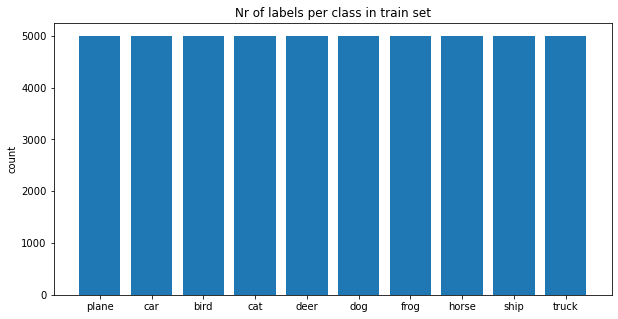

In [17]:
# retrieve train label class count
train_label_count = list()
for samples, labels in train_loader:
    train_label_count.extend(labels.numpy())
train_label_count = {classes_map[i]: train_label_count.count(i) for i in set(train_label_count)}

plt.figure(figsize=(10,5))
plt.bar(list(train_label_count.keys()), list(train_label_count.values()))
plt.title("Nr of labels per class in train set")
plt.ylabel("count")
plt.show()

**Description:** As can be seen in the visualisation above, the training set has balanced class labels. There are 5000 labels per class for all ten classes which results in 50'000 labels total within the trainig set. Next we want to examine the test set.

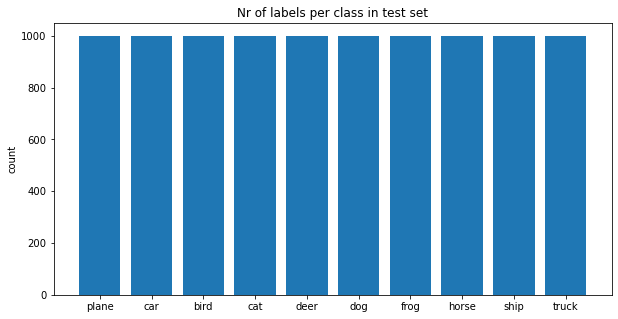

In [18]:
# retrieve test label class count
test_label_count = list()
for samples, labels in test_loader:
    test_label_count.extend(labels.numpy())
test_label_count = {classes_map[i]: test_label_count.count(i) for i in set(test_label_count)}

plt.figure(figsize=(10,5))
plt.bar(list(test_label_count.keys()), list(test_label_count.values()))
plt.title("Nr of labels per class in test set")
plt.ylabel("count")
plt.show()

**Description:** The test set also has balanced class labels. There are 1000 samples per class in the test set which means in total, our test set has 10,000 samples. Knowing the size of the train and test set are able to retrieve calculate the split ratio in the CIFAR10 dataset. The resulting split ratio is therefore 5 to 1 between the train and test set.

### Select sample batch of images

In [19]:
example_batch = iter(train_loader)
samples, labels = example_batch.next()
print("Sample Dimensions:", samples.shape, "\nLabel Dimension:", labels.shape)

Sample Dimensions: torch.Size([32, 3, 32, 32]) 
Label Dimension: torch.Size([32])


**Description:** We now see the dimensions of a selected batch from the training set. The sample dimension is 32, 3, 32, 32. These dimensions are composed as follows:
**32** samples,
**3** colour dimensions (RGB),
**32** pixels image height,
**32** pixels image width.
The label dimension is simply 32 for the labels of the **32** samples.

### Visualization of a single batch

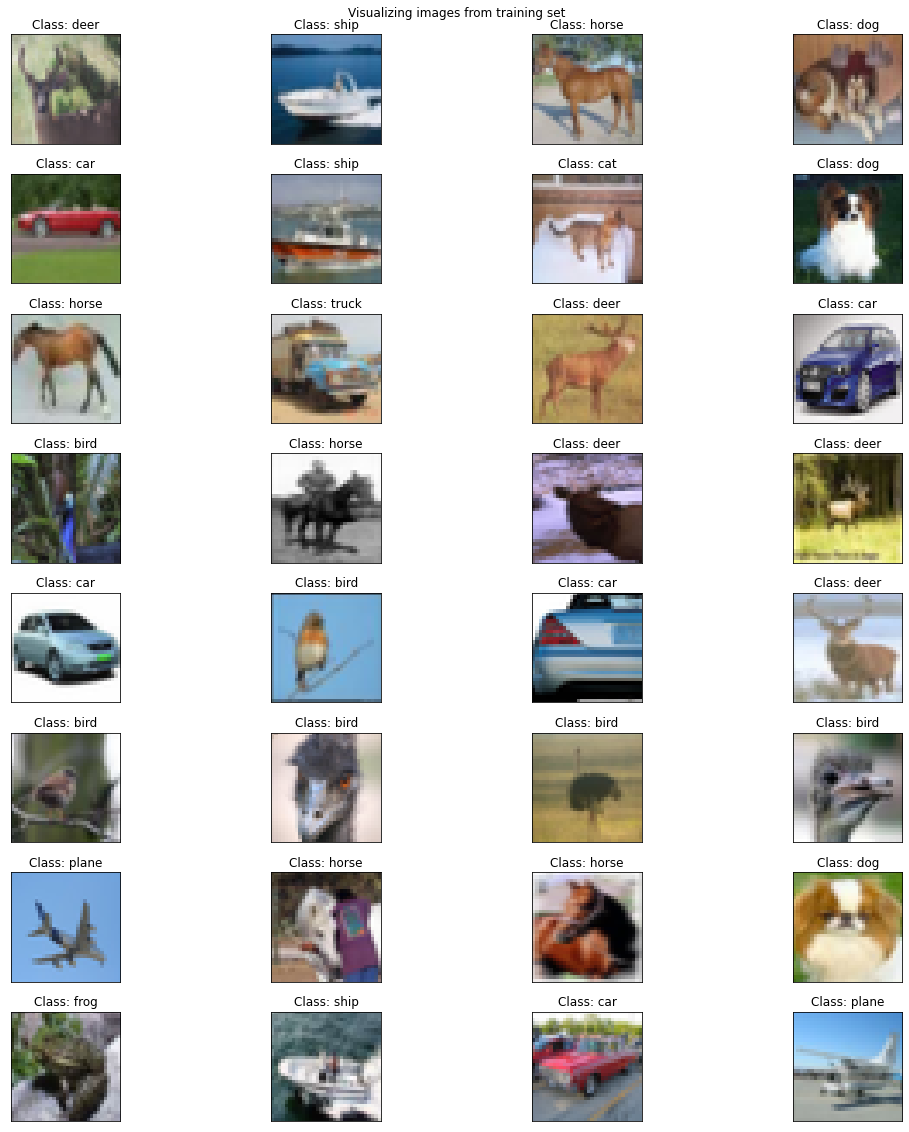

In [20]:
m = 8
n = batch_size // m

fig, axes = plt.subplots(m, n, figsize=(16,16))
for i, image in enumerate(range(batch_size)):
    axes[i//n, i%n].imshow(samples[i].permute(1, 2, 0))
    axes[i//n, i%n].title.set_text("Class: {}".format(classes[labels[i]]))
    axes[i//n, i%n].set_xticks([])
    axes[i//n, i%n].set_yticks([])


plt.suptitle("Visualizing images from training set")
plt.tight_layout()
plt.show()

**Description:** Above we see our randomly drawn training batch. The respective class labels are present in the title. As we can see, the images are not always easy to recognise, even for a human being, due to the low resolution. The biggest advantage of the minimal resolution is the reduction of the features that our model has to take into account, which means that we can use simpler models and correspondingly need less training time.

## Define the target metrics 
In this notebook, a set of metrics are used for the evaluation. 

Since we want to solve a multiclass classification task, the hyperparameter optimization is done primarily by using the cross entropy loss and the balanced accuracy. The score for a perfect prediction would be zero. The initial score of a modell should therefore be higher and start to converge to a lower value. For more information on pytorchs CrossEntropyLoss see: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

Because the dataset has the same proportion of labels within each of its classes, the accuracy equals the balanced accuracy. The accuracy varies in theory between 0 which is the worst possible and 1 which is a perfect prediction. In reality, the accuracy score of our models should start at around 0.1 since we have 10 classes, and it is what could be expected on random prediction of untrained models. 


## Define Models

In [21]:
class MLPNet_2_layer(nn.Module):
    '''Multi Layer Perceptron Net class with 2 layers'''
    def __init__(self, fc_hidden_1, fc_hidden_2=None, fc_hidden_3=None, activation=F.relu, drop_out=0):
        super(MLPNet_2_layer, self).__init__()
        self.fc1 = nn.Linear(in_features=32*32*3, out_features=fc_hidden_1)
        self.fc2 = nn.Linear(in_features=fc_hidden_1, out_features=10)
        self.dropout = nn.Dropout(drop_out)
        self.activation = activation # activation function
    
    def forward(self, x):
        batch_size  = x.shape[0]
        x = x.view(batch_size, -1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class MLPNet_3_layer(nn.Module):
    '''Multi Layer Perceptron Net class with 3 layers'''
    def __init__(self, fc_hidden_1, fc_hidden_2, fc_hidden_3=None, activation=F.relu, drop_out=0):
        super(MLPNet_3_layer, self).__init__()
        self.fc1 = nn.Linear(in_features=32*32*3, out_features=fc_hidden_1)
        self.fc2 = nn.Linear(in_features=fc_hidden_1, out_features=fc_hidden_2)
        self.fc3 = nn.Linear(in_features=fc_hidden_2, out_features=10)
        self.dropout = nn.Dropout(drop_out)
        self.activation = activation # activation function
    
    def forward(self, x):
        batch_size  = x.shape[0]
        x = x.view(batch_size, -1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class MLPNet_4_layer(nn.Module):
    '''Multi Layer Perceptron Net class with 4 layers'''
    def __init__(self, fc_hidden_1, fc_hidden_2, fc_hidden_3, activation=F.relu, drop_out=0):
        super(MLPNet_4_layer, self).__init__()
        self.fc1 = nn.Linear(in_features=32*32*3, out_features=fc_hidden_1)
        self.fc2 = nn.Linear(in_features=fc_hidden_1, out_features=fc_hidden_2)
        self.fc3 = nn.Linear(in_features=fc_hidden_2, out_features=fc_hidden_3)
        self.fc4 = nn.Linear(in_features=fc_hidden_3, out_features=10)
        self.dropout = nn.Dropout(drop_out)
        self.activation = activation # activation function
    
    def forward(self, x):
        batch_size  = x.shape[0]
        x = x.view(batch_size, -1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
    
class MLPNet_6_layer(nn.Module):
    '''Multi Layer Perceptron Net class with 4 layers'''
    def __init__(self, fc_hidden_1, fc_hidden_2, fc_hidden_3, fc_hidden_4, fc_hidden_5, activation=F.relu, drop_out=0):
        super(MLPNet_6_layer, self).__init__()
        self.fc1 = nn.Linear(in_features=32*32*3, out_features=fc_hidden_1)
        self.fc2 = nn.Linear(in_features=fc_hidden_1, out_features=fc_hidden_2)
        self.fc3 = nn.Linear(in_features=fc_hidden_2, out_features=fc_hidden_3)
        self.fc4 = nn.Linear(in_features=fc_hidden_3, out_features=fc_hidden_4)
        self.fc5 = nn.Linear(in_features=fc_hidden_4, out_features=fc_hidden_5)
        self.fc6 = nn.Linear(in_features=fc_hidden_5, out_features=10)
        self.dropout = nn.Dropout(drop_out)
        self.activation = activation # activation function
    
    def forward(self, x):
        batch_size  = x.shape[0]
        x = x.view(batch_size, -1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.dropout(x)
        x = self.activation(self.fc4(x))
        x = self.dropout(x)
        x = self.activation(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        return x

In [22]:
# load dataset without normalization
train_set, test_set =  define_dataset(normalize=True, path='./../../data')
train_loader, test_loader = define_dataloader(train_set, test_set, batch_size)

Files already downloaded and verified
Files already downloaded and verified


## Define Model Trainer

In [23]:
class ModelTrainer:
    
    def __init__(self, model, train_loader, test_loader, num_epochs, criterion, optimizer):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.num_epochs = num_epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.logger = {
            "train":dict(),
            "test":dict()
        }
        self.best_log = dict()
        self.best_model = None
        
        
    def wandb_log(self, log_dict, e):
        wandb.log(log_dict, step=e)


    def calculate_accuracy(self, pred, true):
        '''Calculates the accuracy for the prediction
        Args: 
            pred: predicted labels
            true: true labels
        Returns:
            accuracy as float
        '''
        return (pred.argmax(1) == true).type(torch.float).sum().item()
    

    def train_loop(self, dataloader, verbose):
        '''
        Loop for a sigle training epoch.
        Args:
            dataloader: pytorch dataloader
        '''
        epoch_accuracy = 0
        epoch_loss = 0
        num_batches = len(dataloader)

        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            # Forward propagation
            pred = self.model(images)
            loss = self.criterion(pred, labels)
            
            # Backward propagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # calculate metrics
            epoch_loss += loss.item()
            epoch_accuracy += self.calculate_accuracy(pred, labels)

        epoch_loss /= num_batches
        epoch_accuracy /= len(dataloader.dataset)
        if verbose:
            print(f"train loss:{epoch_loss}, train accuracy:{epoch_accuracy}")
        return {"train loss":epoch_loss, "train accuracy":epoch_accuracy}


    def test_loop(self, dataloader, label="train"):
        epoch_loss = 0
        epoch_accuracy = 0
        num_batches = len(dataloader)

        with torch.no_grad():
            for i, (images, labels) in enumerate(dataloader):
                images = images.to(device)
                labels = labels.to(device)

                # Forward propagation
                pred = self.model(images)

                # calculate metrics
                epoch_loss += self.criterion(pred, labels).item()
                epoch_accuracy += self.calculate_accuracy(pred, labels)
        epoch_loss /= num_batches
        epoch_accuracy /= len(dataloader.dataset)
        return {"{} loss".format(label): epoch_loss, "{} accuracy".format(label): epoch_accuracy}


    def train(self, verbose=False, include_test_scores=False, early_stopping=False):
        # calculate initial model preformance
        self.logger["train"][0] = self.test_loop(self.train_loader, label="train")
        self.wandb_log(self.logger["train"][0], 0)
        if include_test_scores:
            self.logger["test"][0] = self.test_loop(self.test_loader, label="test")
            self.wandb_log(self.logger["test"][0], 0)
            
            # save init as best model
            self.best_log = self.logger["test"][0]
            self.best_model = copy.deepcopy(self.model)
            self.logger["test"][0]["top test accuracy"] = self.logger["test"][0]["test accuracy"]
            self.wandb_log({"top test accuracy":self.best_log["test accuracy"]}, 0)
            

        for e in range(self.num_epochs):
            if verbose:
                print(f"Epoch: {e+1} ------------------------------")
            
            # train model
            self.logger["train"][e+1] = self.train_loop(self.train_loader, verbose)
            self.wandb_log(self.logger["train"][e+1], e+1)

            # calculate model preformance
            if include_test_scores:
                self.logger["test"][e+1] = self.test_loop(self.test_loader, label="test")
                self.wandb_log(self.logger["test"][e+1], e+1)

                # secure model with best test score
                if self.best_log["test accuracy"] < self.logger["test"][e+1]["test accuracy"]:
                    self.best_log = self.logger["test"][e+1]
                    self.best_model = copy.deepcopy(self.model)
                self.logger["test"][e+1]["top test accuracy"] = self.best_log["test accuracy"]
                self.wandb_log({"top test accuracy":self.best_log["test accuracy"]}, e+1)

                # stop if test accuracy stops increasing for 20 epochs
                if (e >= 20) and early_stopping:
                    if self.logger["test"][e+1]["top test accuracy"] == self.logger["test"][e-19]["top test accuracy"]:
                        break



In [24]:
# num_epochs = 3
# model = ConvNet_5(
#             conv1_channels=120,
#             conv2_channels=120,
#             conv3_channels=120,
#             conv4_channels=120,
#             conv5_channels=120).to(device) # model selection
# learning_rate = 0.01        # learning rate for optimizer
# l2_weight_decay = 0.0       # l2 regularization for optimizer

# trainer = ModelTrainer(
#     model=model, 
#     train_loader=train_loader, 
#     test_loader=test_loader, 
#     num_epochs=num_epochs,
#     criterion=nn.CrossEntropyLoss(),
#     optimizer=torch.optim.SGD(
#         model.parameters(), 
#         lr=learning_rate,
#         weight_decay = l2_weight_decay
#         )
#     )

# trainer.train(verbose=True, include_test_scores=True)

In [25]:
# trainer.logger

In [26]:
# path = "./storage_room"
# filename = "/test.pth"

# if not os.path.exists(path):
#     os.makedirs(path)

# torch.save(trainer.model.state_dict(), path + filename)

## Evaluate Model Size

### MLP architecture

In a first step we want to train a simple MLP with variable number of layers and nodes to see how complex it has to be constructed to be able to learn the training dataset. The number of layers used varies between 2 and 4 (without input layer). Accordingly, the number of hidden layers varies between 1 and 3. The number of nodes also varies between 8 and 200 nodes per layer. For this evaluation, the training per model is stopped after the 100th epoch.

In [27]:
# %wandb simonluder/del_mc1/reports/Layer_Configurations -h 2048

**Description:** If we compare the scores of the different configurations, we notice that the number of nodes in the first layer correlates strongly with the development of the loss and the accuracy. Each of the best models has more than 150 nodes in its first hidden layer. When examining the number of layers, we see that nets with only 1 hidden layer perform minimally worse on average. However, it is also visible that two hidden layers are already sufficient to learn the training dataset almost perfectly after 100 epochs. 

Best model with by train loss:
- 1 hidden layer: train accuracy: *0.9694* train loss: *0.1351*
- 2 hidden layer: train accuracy: *0.9996* train loss: *0.008573*
- 3 hidden layer: train accuracy: *0.9997* train loss: *0.004178*


Based on these findings, in the further part of this notebook MLP's with two hidden layers will be used. With this configuration we know that the network has enough flexibility to form relevant features for the classification and is able to interpret them accordingly. The fixed number of layers also ensures an easyer interpretability between different downstream models during further hyperparameter tuning.

### CNN architecture

The architecture of a Convolutional Neural Network extends the existing structure of our MLP's with Convolutional Layers, followed by a Pooling Layer. The convolutional layer receives as input our 2 dimensional images and the three colour channels (RGB) as a 3d matrix. Then a filter kernel is iterated over the pixels of the matrix window by window. The output for a single pixel is calculated as the scalar product of the iterated window and the filter kernel. The output dimension of the Concolutional Layer can be calculated using the formula below.

</br>

$$H_{out} = \left\lfloor\frac{H_{in} + 2 \times \text{padding}[0] - \text{dilation}[0] \times (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor$$

$$W_{out} = \left\lfloor\frac{W_{in} + 2 \times \text{padding}[1] - \text{dilation}[1] \times (\text{kernel\_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor$$

where

- $W_{in}$: Width of input
- $H_{in}$: Height of input

The subsequent pooling layer is used to filter out excess information. Here, again, a window is iterated over the output of the convolutional layer and a pooling action is performed. The most common method is max pooling, but average pooling is also used for deeper neural networks. This reduces the features of our matrices, while it usually does not reduce the accuracy of our network. Due to the feature reduction, our network is not only faster in computation and training, but it is also possible to train deeper networks. Furthermore, this method prevents overfitting, since the individual features are viewed in a generalised manner within the local iterated window. 


In [28]:
class ConvNet_2(nn.Module):
    '''A convolutional neural network with 2 convolutional layers'''
    def __init__(self, activation=F.relu, kernel_size=5, pool_size=2, conv1_channels = 10, conv2_channels=8, fc_hidden_1=120, fc_hidden_2=84, drop_out=0):
        '''Convolutional Net class'''
        super(ConvNet_2, self).__init__()   
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv1_channels, kernel_size=kernel_size) 
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)
        self.conv2 = nn.Conv2d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size) 
        self.fc1 = nn.Linear(in_features=conv2_channels*5*5, out_features=fc_hidden_1)   
        self.fc2 = nn.Linear(in_features=fc_hidden_1, out_features=fc_hidden_2)
        self.fc3 = nn.Linear(in_features=fc_hidden_2, out_features=10)
        self.dropout = nn.Dropout(drop_out)
        self.activation = activation
        self.conv2_channels = conv2_channels

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = x.view(-1, self.conv2_channels*5*5) # flatten tensor
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class ConvNet_3(nn.Module):
    def __init__(self, activation=F.relu, kernel_size=5, pool_size=2, padding=3, conv1_channels = 10, conv2_channels=8, conv3_channels=8, fc_hidden_1=120, fc_hidden_2=84, drop_out=0):
        '''A convolutional neural network with 3 convolutional layers'''
        super(ConvNet_3, self).__init__()   
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv1_channels, kernel_size=kernel_size, padding=padding) 
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)
        self.conv2 = nn.Conv2d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size, padding=padding) 
        self.conv3 = nn.Conv2d(in_channels=conv2_channels, out_channels=conv3_channels, kernel_size=kernel_size, padding=padding)
        self.fc1 = nn.Linear(in_features=conv3_channels*5*5, out_features=fc_hidden_1)   
        self.fc2 = nn.Linear(in_features=fc_hidden_1, out_features=fc_hidden_2)
        self.fc3 = nn.Linear(in_features=fc_hidden_2, out_features=10)
        self.dropout = nn.Dropout(drop_out)
        self.activation = activation
        self.conv3_channels = conv3_channels

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = x.view(-1, self.conv3_channels*5*5) # flatten tensor
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    
class ConvNet_5(nn.Module):
    def __init__(self, activation=F.relu, kernel_size=5, pool_size=2, padding=3, conv1_channels = 16, conv2_channels=16, conv3_channels=16, conv4_channels=16, conv5_channels=16, fc_hidden_1=120, fc_hidden_2=84, drop_out=0):
        '''A convolutional neural network with 3 convolutional layers'''
        super(ConvNet_5, self).__init__()   
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv1_channels, kernel_size=kernel_size, padding=padding) 
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)
        self.conv2 = nn.Conv2d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size, padding=padding) 
        self.conv3 = nn.Conv2d(in_channels=conv2_channels, out_channels=conv3_channels, kernel_size=kernel_size, padding=padding)
        self.conv4 = nn.Conv2d(in_channels=conv3_channels, out_channels=conv4_channels, kernel_size=kernel_size, padding=padding)
        self.conv5 = nn.Conv2d(in_channels=conv4_channels, out_channels=conv5_channels, kernel_size=kernel_size, padding=padding)
        self.fc1 = nn.Linear(in_features=conv5_channels*2*2, out_features=fc_hidden_1)   
        self.fc2 = nn.Linear(in_features=fc_hidden_1, out_features=fc_hidden_2)
        self.fc3 = nn.Linear(in_features=fc_hidden_2, out_features=10)
        self.dropout = nn.Dropout(drop_out)
        self.activation = activation
        self.conv5_channels = conv5_channels

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = self.pool(self.activation(self.conv4(x)))
        x = self.pool(self.activation(self.conv5(x)))
        x = x.view(-1, self.conv5_channels*2*2) # flatten tensor
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [29]:
ConvNet_5()

ConvNet_5(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (conv3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (conv4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (conv5): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (fc1): Linear(in_features=64, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

## Model Evaluation

In this section, different model constelations are examined for their performance. The evaluation is done by using Baesiean Search. The optimization is done with respect to the accuracy.

In [30]:
def save_model(path, model, name):
        '''
        Saves the model as state dict.
        Args:
            path (str): path where to save the model
        '''
        filename = "/{}.pt".format(name)
        if not os.path.exists(path):
            os.makedirs(path)
        torch.save(model, path + filename)

In [31]:
def train_mlp_2(config=None):
    '''Trains and logs a multilayer perceptron'''
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        
        # define model
        model = MLPNet_2_layer(
            fc_hidden_1=config["hidden_layers"][0],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"]))
        
        #train model
        trainer.train(verbose=False, include_test_scores=True)
        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)


def train_mlp_3(config=None):
    '''Trains and logs a multilayer perceptron'''
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        
        # define model
        model = MLPNet_3_layer(
            fc_hidden_1=config["hidden_layers"][0],
            fc_hidden_2=config["hidden_layers"][1],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"]))
        
        #train model
        trainer.train(verbose=False, include_test_scores=True)
        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)


def train_mlp_4(config=None):
    '''Trains and logs a multilayer perceptron'''
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        
        # define model
        model = MLPNet_4_layer(
            fc_hidden_1=config["hidden_layers"][0],
            fc_hidden_2=config["hidden_layers"][1],
            fc_hidden_3=config["hidden_layers"][2],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"]))
        
        #train model
        trainer.train(verbose=False, include_test_scores=True)
        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)
            
def train_mlp_6(config=None):
    '''Trains and logs a multilayer perceptron'''
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        
        # define model
        model = MLPNet_6_layer(
            fc_hidden_1=config["hidden_layers"][0],
            fc_hidden_2=config["hidden_layers"][1],
            fc_hidden_3=config["hidden_layers"][2],
            fc_hidden_4=config["hidden_layers"][3],
            fc_hidden_5=config["hidden_layers"][4],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"]))
        
        #train model
        trainer.train(verbose=False, include_test_scores=True)
        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)
            
def train_cnn_2(config=None):
    '''Trains and logs a convolutional neuronal network'''
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        
        # define model
        model = ConvNet_2(
            kernel_size=config["kernel_size"],
            pool_size=config["pool_size"],
            conv1_channels=config["conv_layers"][0],
            conv2_channels=config["conv_layers"][1],
            fc_hidden_1=config["hidden_layers"][0],
            fc_hidden_2=config["hidden_layers"][1],
            drop_out=config["drop_out"],
            ).to(device) 
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"]))
        
        #train model
        trainer.train(verbose=False, include_test_scores=True)
        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)
            
def train_cnn_3(config=None):
    '''Trains and logs a convolutional neuronal network'''
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        
        # define model
        model = ConvNet_3(
            kernel_size=config["kernel_size"],
            pool_size=config["pool_size"],
            conv1_channels=config["conv_layers"][0],
            conv2_channels=config["conv_layers"][1],
            conv3_channels=config["conv_layers"][2],
            fc_hidden_1=config["hidden_layers"][0],
            fc_hidden_2=config["hidden_layers"][1],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"]))
        
        #train model
        trainer.train(verbose=False, include_test_scores=True)
        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)
            
def train_cnn_5(config=None):
    '''Trains and logs a convolutional neuronal network'''
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        
        # define model
        model = ConvNet_5(
            kernel_size=config["kernel_size"],
            pool_size=config["pool_size"],
            conv1_channels=config["conv_layers"][0],
            conv2_channels=config["conv_layers"][1],
            conv3_channels=config["conv_layers"][2],
            conv4_channels=config["conv_layers"][3],
            conv5_channels=config["conv_layers"][4],
            fc_hidden_1=config["hidden_layers"][0],
            fc_hidden_2=config["hidden_layers"][1],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"]))
        
        #train model
        trainer.train(verbose=False, include_test_scores=True)
        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)

### Training with SGD (without REG, without BN)

In [32]:
num_epochs = 3
min_acc = 0.7
create_sweep = True #create new sweeps

# create initial sweep configuration
mlp_sweep_configuration = {
    "name": "MLP_sweep",
    "metric": {"name": "test accuracy", "goal": "minimize"},
    "method": "grid",
    "parameters": {
        "variant": {
            "value": "MLP_SGD"
        },
        "num_hidden": {
            "value": 1
        },
        "hidden_layers": {
            "values":[(32,), (64,), (128,), (256,)]
        },
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "values": [0.2, 0.1, 0.05, 0.02]
        },
        "l2_weight_decay": {
            "value": 0
        },
        "drop_out": {
            "value": 0
        },
    }
}

# run 2 layer mlp
if create_sweep:
    sweep_id = wandb.sweep(mlp_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_mlp_2)

    
# update sweep configuration for 3 layers mlp
mlp_sweep_configuration["parameters"].update({
    "num_hidden": {"value": 2},
    "hidden_layers": {"values":[(32,32), (64,64), (128,128), (256,256)]}})
# run 3 layer mlp
if create_sweep:
    sweep_id = wandb.sweep(mlp_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_mlp_3)

    
# update sweep configuration for 4 layers mlp
mlp_sweep_configuration["parameters"].update({
    "num_hidden": {"value": 3},
    "hidden_layers": {"values":[(32,32,32), (64,64,64), (128,128,128), (256,256,256)]}})
# run 4 layer mlp
if create_sweep:
    sweep_id = wandb.sweep(mlp_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_mlp_4)

    
# update sweep configuration for 6 layers mlp
mlp_sweep_configuration["parameters"].update({
    "num_hidden": {"value": 5},
    "hidden_layers": {"values":[(32,32,32,32,32), (64,64,64,64,64), (128,128,128,128,128), (256,256,256,256,256)]}}) 
# run 6 layer mlp
if create_sweep:
    sweep_id = wandb.sweep(mlp_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_mlp_6)

In [ ]:
num_epochs = 100
min_acc = 0.7
create_sweep = True #create new sweeps

# create initial sweep configuration
cnn_sweep_configuration = {
    "name": "CNN_sweep",
    "metric": {"name": "test accuracy", "goal": "minimize"},
    "method": "grid",
    "parameters": {
        "variant": {
            "value": "CNN_SGD"
        },
        "num_conv": {
            "value": 2
        },
        "conv_layers": {
            "values": [(32, 32),(64, 64),(128,128),(256,256)]
        },
        "num_hidden": {
            "value": 2
        },
        "hidden_layers": {
            "values": [(128, 64),]
        },
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "values": [0.2, 0.1, 0.05, 0.02]
        },
        "l2_weight_decay": {
            "value": 0
        },
        "drop_out": {
            "value": 0
        },
        "kernel_size": {
            "value": 5
        },
        "pool_size": {
            "value": 2
        },
    }
}

# run 2 cnn 2 mlp layer
if create_sweep:
    sweep_id = wandb.sweep(cnn_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_cnn_2)

    
# update sweep configuration for 3 layers cnn
cnn_sweep_configuration["parameters"].update({
    "num_conv": {"value": 3},
    "conv_layers": {"values":[(32,32,32), (64,64,64), (128,128,128), (256,256,256)]}})
# run 3 cnn 2 mlp layer
if create_sweep:
    sweep_id = wandb.sweep(cnn_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_cnn_3)

    
# update sweep configuration for 5 layers cnn
cnn_sweep_configuration["parameters"].update({
    "num_conv": {"value": 5},
    "conv_layers": {"values":[(32,32,32,32,32), (64,64,64,64,64), (128,128,128,128,128), (256,256,256,256,256)]}})
# run 5 cnn 2 mlp layer
if create_sweep:
    sweep_id = wandb.sweep(cnn_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_cnn_5)

Create sweep with ID: wdl01g4i
Sweep URL: https://wandb.ai/simonluder/del-mc1/sweeps/wdl01g4i





**Model:** 2022-05-14-13-33-02 **Test Accurcacy:** 0.7613

In [ ]:
%wandb simonluder/del_mc1/reports/Layer_Configurations -h 2048

### Inclusion of Regularization

#### L2 Regularization

The Ridge regression adds the “squared magnitude” of all weights as penalty a term to the loss function. It is relevant how strongly the regularization is weighted in the calculation of the cost function. The strength of the regularization can be set via the hyperparameter *lambda*: $\lambda$. If lambda is 0, then the regularization is not included in the optimization, which corresponds to the OLS variant used before. The higher lambda is chosen, the more the individual weights are decreased. L2 regularization therefore disperse the error terms in all the weights which leads to more accurate customized final models.

In [ ]:
num_epochs = 100
num_runs = 5
min_acc = 0.7

create_sweep = False #create new sweeps


mlp_sweep_configuration = {
    "name": "MLP_sweep",
    "metric": {"name": "test accuracy", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "name": {
            "value": "MLP_SGD_L2"
        },
        "fc_hidden_1": {
            "distribution": "int_uniform",
            "max":200,
            "min":50
        },
        "fc_hidden_2": {
            "distribution": "int_uniform",
            "max":180,
            "min":50
        },
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "values": [0.1, 0.05]
        },
        "l2_weight_decay": {
            "values": [0, 0.05, 0.1, 0.2]
        },
        "drop_out": {
            "value": 0
        },
    }
}

def train(config=None):
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        # define model
        model = MLPNet_3_layer(
            fc_hidden_1=config["fc_hidden_1"],
            fc_hidden_2=config["fc_hidden_2"],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"],
                )
            )
            
        #train model
        trainer.train(verbose=False, include_test_scores=True)

        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)
       
if create_sweep:
    sweep_id = wandb.sweep(mlp_sweep_configuration, project="del_mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train, count=num_runs)

In [ ]:
num_epochs = 100
num_runs = 5
min_acc = 0.7

create_sweep = False #create new sweeps

cnn_sweep_configuration = {
    "name": "CNN_sweep",
    "metric": {"name": "test accuracy", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "name": {
            "value": "CNN_SGD_L2"
        },
        "conv1_channels": {
            "values":[4, 8, 16, 32]
        },
        "conv2_channels": {
            "values":[4, 8, 16, 32]
        },
        "fc_hidden_1": {
            "distribution": "int_uniform",
            "max":190,
            "min":150
        },
        "fc_hidden_2": {
            "distribution": "int_uniform",
            "max":190,
            "min":50
        },
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "values": [0.1, 0.05]
        },
        "l2_weight_decay": {
            "values": [0, 0.05, 0.1, 0.2]
        },
        "drop_out": {
            "value": 0
        },
        "kernel_size": {
            "value": 5
        },
        "pool_size": {
            "value": 2
        },
    }
}


def train(config=None):
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        # define model
        model = ConvNet(
            kernel_size=config["kernel_size"],
            pool_size=config["pool_size"],
            conv1_channels=config["conv1_channels"],
            conv2_channels=config["conv2_channels"],
            fc_hidden_1=config["fc_hidden_1"],
            fc_hidden_2=config["fc_hidden_2"],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"],
                )
            )
            
        #train model
        trainer.train(verbose=False, include_test_scores=True)

        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)
       
if create_sweep:
    sweep_id = wandb.sweep(cnn_sweep_configuration, project="del_mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train, count=num_runs)

**Description:** The effect of L2 regularisation is clearly visible in the training loss. Using the L2 regularisation parameter prevents the training loss from completely converging to 0. The higher the value of the regularisation parameter, the earlier the conversion stops. However, L2 regularisation did not improve the test loss. 

#### Drop out Regulatization

With drop out regularization, a specified percentage of the output values of the nodes within a layer are swept out and their value is set to zero. The selection of the nodes occurs randomly and is repeated for each batch. By ignoring individual node outputs in training, it ensures that the model cannot solely rely on individual nodes for making a classification. This causes the individual edge weights to be lowered overall, which should produce an effect similar to that of L2 regularization.

In [ ]:
num_epochs = 100
num_runs = 5
min_acc = 0.7

create_sweep = False #create new sweeps


mlp_sweep_configuration = {
    "name": "MLP_sweep",
    "metric": {"name": "test accuracy", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "name": {
            "value": "MLP_SGD_DP"
        },
        "fc_hidden_1": {
            "distribution": "int_uniform",
            "max":200,
            "min":100
        },
        "fc_hidden_2": {
            "distribution": "int_uniform",
            "max":180,
            "min":70
        },
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "values": [0.1, 0.05]
        },
        "l2_weight_decay": {
            "value": 0
        },
        "drop_out": {
            "values": [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
        },
    }
}

def train(config=None):
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        # define model
        model = MLPNet_3_layer(
            fc_hidden_1=config["fc_hidden_1"],
            fc_hidden_2=config["fc_hidden_2"],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"],
                )
            )
            
        #train model
        trainer.train(verbose=False, include_test_scores=True)

        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)
       
if create_sweep:
    sweep_id = wandb.sweep(mlp_sweep_configuration, project="del_mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train, count=num_runs)

In [ ]:
num_epochs = 100
num_runs = 5
min_acc = 0.7

create_sweep = False #create new sweeps

cnn_sweep_configuration = {
    "name": "CNN_sweep",
    "metric": {"name": "test accuracy", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "name": {
            "value": "CNN_SGD_DP"
        },
        "conv1_channels": {
            "values":[4, 8, 16, 32]
        },
        "conv2_channels": {
            "values":[4, 8, 16, 32]
        },
        "fc_hidden_1": {
            "distribution": "int_uniform",
            "max":190,
            "min":150
        },
        "fc_hidden_2": {
            "distribution": "int_uniform",
            "max":190,
            "min":50
        },
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "values": [0.1, 0.05]
        },
        "l2_weight_decay": {
            "value": 0
        },
        "drop_out": {
            "values": [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
        },
        "kernel_size": {
            "value": 5
        },
        "pool_size": {
            "value": 2
        },
    }
}


def train(config=None):
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        # define model
        model = ConvNet(
            kernel_size=config["kernel_size"],
            pool_size=config["pool_size"],
            conv1_channels=config["conv1_channels"],
            conv2_channels=config["conv2_channels"],
            fc_hidden_1=config["fc_hidden_1"],
            fc_hidden_2=config["fc_hidden_2"],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"],
                )
            )
            
        #train model
        trainer.train(verbose=False, include_test_scores=True)

        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)
       
if create_sweep:
    sweep_id = wandb.sweep(cnn_sweep_configuration, project="del_mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train, count=num_runs)

### Including Batchnorm BN (without REG)

Batchnormalization is a popular method to improve the training of deep neural networks, where there is an effect that can occur with an extended number of layers: the so-called *internal covariance shift*. This describes the phenomenon when the distribution of the activation values of a layer is changed by adjusting the weights of the prior layer. The adjustments of all preceding layers thus have an influence on the distributions of all activations of subsequent layers. The subsequent layers therefore must adapt to these changes. As a result, the training is significantly slowed down.

Batch normalisation aims, as the name suggests, to normalise the distribution of activation values per batch for each layer, which reduces the variation of activation values per layer to a more defined range. Batch normalisation can thus also be seen as a kind of smoothing of the cost function in each layer, which in turn reduces the variation of the gradient lengths and thus leads to a more stable learning behaviour.

In [ ]:
class MLPNet_3_layer_bn(nn.Module):
    '''Multi Layer Perceptron Net class with 3 layers'''
    def __init__(self, fc_hidden_1, fc_hidden_2, fc_hidden_3=None, activation=F.relu, drop_out=0):
        super(MLPNet_3_layer_bn, self).__init__()
        self.fc1 = nn.Linear(in_features=32*32*3, out_features=fc_hidden_1)
        self.fc1_bn = nn.BatchNorm1d(fc_hidden_1)
        self.fc2 = nn.Linear(in_features=fc_hidden_1, out_features=fc_hidden_2)
        self.fc2_bn = nn.BatchNorm1d(fc_hidden_2)
        self.fc3 = nn.Linear(in_features=fc_hidden_2, out_features=10)
        self.dropout = nn.Dropout(drop_out)
        self.activation = activation # activation function
    
    def forward(self, x):
        batch_size  = x.shape[0]
        x = x.view(batch_size, -1)
        x = self.activation(self.fc1_bn(self.fc1(x)))
        x = self.dropout(x)
        x = self.activation(self.fc2_bn(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class ConvNet_bn(nn.Module):
    def __init__(self, activation=F.relu, kernel_size=5, pool_size=2, conv1_channels = 10, conv2_channels=8, fc_hidden_1=120, fc_hidden_2=84, drop_out=0):
        '''Convolutional Net class'''
        super(ConvNet_bn, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv1_channels, kernel_size=kernel_size) 
        self.conv1_bn=nn.BatchNorm2d(conv1_channels)
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)
        self.conv2 = nn.Conv2d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size) 
        self.conv2_bn=nn.BatchNorm2d(conv2_channels)
        self.fc1 = nn.Linear(in_features=conv2_channels*5*5, out_features=fc_hidden_1)
        self.fc1_bn = nn.BatchNorm1d(fc_hidden_1)
        self.fc2 = nn.Linear(in_features=fc_hidden_1, out_features=fc_hidden_2)
        self.fc2_bn = nn.BatchNorm1d(fc_hidden_2)
        self.fc3 = nn.Linear(in_features=fc_hidden_2, out_features=10)
        self.dropout = nn.Dropout(drop_out)
        self.activation = activation
        self.conv2_channels = conv2_channels


    def forward(self, x):
        x = self.pool(self.activation(self.conv1_bn(self.conv1(x))))
        x = self.pool(self.activation(self.conv2_bn(self.conv2(x))))
        x = x.view(-1, self.conv2_channels*5*5) # flatten tensor
        x = self.activation(self.fc1_bn(self.fc1(x)))
        x = self.dropout(x)
        x = self.activation(self.fc2_bn(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


class ConvNet_3_bn(nn.Module):
    def __init__(self, activation=F.relu, kernel_size=5, pool_size=2, padding=3, conv1_channels = 10, conv2_channels=8, conv3_channels=8, fc_hidden_1=120, fc_hidden_2=84, drop_out=0):
        '''A convolutional neural network with 3 convolutional layers'''
        super(ConvNet_3_bn, self).__init__()   
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv1_channels, kernel_size=kernel_size, padding=padding) 
        self.conv1_bn=nn.BatchNorm2d(conv1_channels)
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)
        self.conv2 = nn.Conv2d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size, padding=padding) 
        self.conv2_bn=nn.BatchNorm2d(conv2_channels)
        self.conv3 = nn.Conv2d(in_channels=conv2_channels, out_channels=conv3_channels, kernel_size=kernel_size, padding=padding)
        self.conv3_bn=nn.BatchNorm2d(conv3_channels)
        self.fc1 = nn.Linear(in_features=conv3_channels*5*5, out_features=fc_hidden_1)   
        self.fc1_bn = nn.BatchNorm1d(fc_hidden_1)
        self.fc2 = nn.Linear(in_features=fc_hidden_1, out_features=fc_hidden_2)
        self.fc2_bn = nn.BatchNorm1d(fc_hidden_2)
        self.fc3 = nn.Linear(in_features=fc_hidden_2, out_features=10)
        self.dropout = nn.Dropout(drop_out)
        self.activation = activation
        self.conv3_channels = conv3_channels

    def forward(self, x):
        x = self.pool(self.activation(self.conv1_bn(self.conv1(x))))
        x = self.pool(self.activation(self.conv2_bn(self.conv2(x))))
        x = self.pool(self.activation(self.conv3_bn(self.conv3(x))))
        x = x.view(-1, self.conv3_channels*5*5) # flatten tensor
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [ ]:
num_epochs = 100
num_runs = 5
min_acc = 0.7

create_sweep = False #create new sweeps


mlp_sweep_configuration = {
    "name": "MLP_sweep",
    "metric": {"name": "test accuracy", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "name": {
            "value": "MLP_SGD_BN"
        },
        "fc_hidden_1": {
            "distribution": "int_uniform",
            "max":200,
            "min":100
        },
        "fc_hidden_2": {
            "distribution": "int_uniform",
            "max":180,
            "min":70
        },
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "values": [0.1, 0.05]
        },
        "l2_weight_decay": {
            "value": 0
        },
        "drop_out": {
            "value": 0
        },
    }
}

def train(config=None):
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        # define model
        model = MLPNet_3_layer_bn(
            fc_hidden_1=config["fc_hidden_1"],
            fc_hidden_2=config["fc_hidden_2"],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"],
                )
            )
            
        #train model
        trainer.train(verbose=False, include_test_scores=True)

        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)
       
if create_sweep:
    sweep_id = wandb.sweep(mlp_sweep_configuration, project="del_mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train, count=num_runs)

In [ ]:
num_epochs = 100
num_runs = 5
min_acc = 0.7

create_sweep = False #create new sweeps

cnn_sweep_configuration = {
    "name": "CNN_sweep",
    "metric": {"name": "test accuracy", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "name": {
            "value": "CNN_SGD_BN"
        },
        "conv1_channels": {
            "values":[4, 8, 16, 32]
        },
        "conv2_channels": {
            "values":[4, 8, 16, 32]
        },
        "fc_hidden_1": {
            "distribution": "int_uniform",
            "max":190,
            "min":150
        },
        "fc_hidden_2": {
            "distribution": "int_uniform",
            "max":190,
            "min":50
        },
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "values": [0.1, 0.05]
        },
        "l2_weight_decay": {
            "value": 0
        },
        "drop_out": {
            "value": 0
        },
        "kernel_size": {
            "value": 5
        },
        "pool_size": {
            "value": 2
        },
    }
}


def train(config=None):
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        # define model
        model = ConvNet_bn(
            kernel_size=config["kernel_size"],
            pool_size=config["pool_size"],
            conv1_channels=config["conv1_channels"],
            conv2_channels=config["conv2_channels"],
            fc_hidden_1=config["fc_hidden_1"],
            fc_hidden_2=config["fc_hidden_2"],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"],
                )
            )
            
        #train model
        trainer.train(verbose=False, include_test_scores=True)

        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)
       
if create_sweep:
    sweep_id = wandb.sweep(cnn_sweep_configuration, project="del_mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train, count=num_runs)

### Using Adam (without BN)

In [ ]:
num_epochs = 100
num_runs = 5
min_acc = 0.7
create_sweep = False #create new sweeps


mlp_sweep_configuration = {
    "name": "MLP_sweep",
    "metric": {"name": "test accuracy", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "name": {
            "value": "MLP_SGD_ADAM"
        },
        "fc_hidden_1": {
            "distribution": "int_uniform",
            "max":200,
            "min":80
        },
        "fc_hidden_2": {
            "distribution": "int_uniform",
            "max":180,
            "min":50
        },
        "fc_hidden_3": {
            "distribution": "int_uniform",
            "max":180,
            "min":50
        },
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "values": [0.1, 0.05]
        },
        "l2_weight_decay": {
            "value": 0
        },
        "drop_out": {
            "value": 0
        },
    }
}

def train(config=None):
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        # define model
        model = MLPNet_4_layer(
            fc_hidden_1=config["fc_hidden_1"],
            fc_hidden_2=config["fc_hidden_2"],
            fc_hidden_3=config["fc_hidden_3"],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.Adam(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"],
                )
            )
            
        #train model
        trainer.train(verbose=False, include_test_scores=True)

        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)
       
if create_sweep:
    sweep_id = wandb.sweep(mlp_sweep_configuration, project="del_mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train, count=num_runs)

In [ ]:
num_epochs = 100
num_runs = 5
min_acc = 0.7
create_sweep = False #create new sweeps

cnn_sweep_configuration = {
    "name": "CNN_sweep",
    "metric": {"name": "test accuracy", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "name": {
            "value": "CNN_SGD_ADAM"
        },
        "conv1_channels": {
            "values":[32, 64, 128]
        },
        "conv2_channels": {
            "values":[32, 64, 128]
        },
        "conv3_channels": {
            "values":[32, 64, 128]
        },
        "fc_hidden_1": {
            "distribution": "int_uniform",
            "max":190,
            "min":150
        },
        "fc_hidden_2": {
            "distribution": "int_uniform",
            "max":190,
            "min":50
        },
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "values": [0.1, 0.05]
        },
        "l2_weight_decay": {
            "value": 0
        },
        "drop_out": {
            "value": 0
        },
        "kernel_size": {
            "value": 5
        },
        "pool_size": {
            "value": 2
        },
    }
}


def train(config=None):
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        # define model
        model = ConvNet_3(
            kernel_size=config["kernel_size"],
            pool_size=config["pool_size"],
            conv1_channels=config["conv1_channels"],
            conv2_channels=config["conv2_channels"],
            conv3_channels=config["conv3_channels"],
            fc_hidden_1=config["fc_hidden_1"],
            fc_hidden_2=config["fc_hidden_2"],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.Adam(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"],
                )
            )
            
        #train model
        trainer.train(verbose=False, include_test_scores=True)

        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)
       
if create_sweep:
    sweep_id = wandb.sweep(cnn_sweep_configuration, project="del_mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train, count=num_runs)

The first noticeable change is the change in the optimal learning rate. While our previous variants had an optimal learning rate between 0.1 and 0.05, with the Adam optimizer this rate is clearly too high and leads to an unstable learning behaviour. It seems that for our models in the CIFAR10 data set, a 10 times smaller learning rate is necessary to achieve a stable training behaviour.